# Reinforcement Learning Project 2: Deep Q-Networks

In [43]:
import gym

import numpy as np
import matplotlib.pyplot as plt

import random
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from collections import deque 
from copy import deepcopy


## 1.1 Defining the Deep Q-Network

Q-Learning, like other Tabular methods, saves the Q-values( state-action pair values) in a table which the agent uses to make an optimal decisions at each time step in an environment. While this helps in environments with limited state space and action space, it can blow out of proportions in an environments with large action and state spaces. In Deep Q-Networks, we use a neural network as a value approximator function, which takes the state as input and returns values corresponding to each action the agent can take at that state, as output. The advantage of doing so is that instead of maintaining a table and updating it every timestep, we call a function.

In addition, rather that using sequential data to train our neural network, we use a replay memory. Sequential data is temporally correlated and to optimize our predictions, we need the data to be independently and identically distributed(iid). In order to break this temporal correlation in the input data, we store the last N recent sequences (state, action, reward and resulting state) into a replay memory and take random samples from the sequential memory in order to train out neural networks.

We also use two neural networks to train our model, one used to predict all the action values and another only used to predict the q values to train the action predicting network. The reason for using a separate network for generating the targets is to improve stability by fixing the target for N timesteps thereby reducing oscillations caused by a moving target. The second Q network, named target network, has it's weights updated after a fixed number of timesteps by copying the weights of the acton value predicting network.

We use the two networks as follows:

    > Compute Q-learning with respect to fixed parameters w-
   $r + \gamma max_{a'}Q(s',a', w^{-}) $
   
    >Optimize Mean Square Error between Q-network estimating action values and Q-network estimating targets
   
  $L(w) = E_{(s,a,r,s')~D}[(r + \gamma max_{a'}Q(s',a',w^{-} - Q(s,a,w))^{2}]$
  
      where (s,a,r,s') are sequences of transitions stored in the replay memory of size D

### Defining the Agent

In [12]:
#Class for the DQN and the Replay Memory and their operations
class DQN_Agent:
    def __init__(self, action_space, observation_space, gamma = 0.99, max_memory = 10000, epsilon=1.0, epsilon_decay=0.999, hidden_layer_size=32, learning_rate = 0.001):
        self.action_space = action_space
        self.observation_space = observation_space
        self.max_memory = max_memory
        self.gamma = gamma
        self.epsilon = epsilon 
        self.epsilon_min = 0.1
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate
        self.hidden_layer_size = hidden_layer_size
        self.tau = 0.01

        #Used for Replay Memory
        self.memory = deque(maxlen = self.max_memory)
        
        #Used to determine Action Values
        self.model = self.create_model()
        
        #Used to determine Target Values
        self.target_model = deepcopy(self.model)
        
        #Used to determine DDQN Target Values
        self.ddqn_target_model = self.create_model()
        
        #To store the history of Q value predictions
        self.history = []
        self.DDQN_history = []

    #Creates the DQN which will work as Q-value approximation function
    def create_model(self):
        model = Sequential()
        model.add(Dense(self.hidden_layer_size, activation='relu', input_shape = (self.observation_space.shape[0],)))
        model.add(Dense(self.hidden_layer_size-10, activation='relu'))
        model.add(Dense(self.hidden_layer_size-10, activation='relu'))
        model.add(Dense(self.action_space.n, activation='linear'))
        optimizer = SGD(lr=self.learning_rate)
        model.compile(loss='mse',optimizer= optimizer)    
        return model

    
    #Add a transition containing (state, action, reward, next_state, done) to the Replay Memory
    def add_to_memory(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

        
    #Pick a batch_size sample of transitions randomly from the replay memory
    def sample_from_memory(self, batch_size):
        return random.sample(self.memory, batch_size)

    
    #Select an action to be sent to the emulator from the current state using epsilon-greedy technique
    def select_action(self, state):

        #Exploration
        if random.random() < self.epsilon:
            return self.action_space.sample()

        #Exploitation
        action = self.model.predict(state)[0]
        return np.argmax(action)

    
    
    #Decay the epsilon value so that exploitation can take over after sufficient exploration
    def decay_epsilon(self):
        if(self.epsilon > self.epsilon_min):
            self.epsilon *= self.epsilon_decay

    #Update the weights of the target model using the weights of the action model
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    #Update the weights of the target model for Double-DQN
    #Please note: used in section 2: Double DQN
    def update_ddqn_target_model(self):
        w1 = self.ddqn_target_model.get_weights()
        w2 = self.model.get_weights()
        new_w = self.tau * np.array(w2) + (1 - self.tau) * np.array(w1)
        self.ddqn_target_model.set_weights(new_w)

    #Sample values from the replay memory and train the model 
    def memory_replay(self, batch_size, t):

        if len(self.memory) <= batch_size:
            return
        
        #Sample a batch of values from the Replay Memory
        #Please note: Values of state and next_stateare stored in the main memory in the form [[value]].
        batch = self.sample_from_memory(batch_size)
        x_values = []
        y_values = []
        
        for state, action, reward, next_state, done in batch:
            #target q-value when the next state is terminal
            target = reward
            
            if not done:
                #Calculate target q-value when the next state is not terminal
                target = (reward + self.gamma * np.amax(self.target_model.predict(next_state)[0]))
            
            #Predict the q-values for all the actions in the current state using action network 
            q_values = self.model.predict(state)
            
            #Update the predicted Q-value with the target value 
            q_values[0][action] = target
            
            #Collect all state values in a batch
            x_values.append(state[0])
            
            #Collect all the predicted q-values
            y_values.append(q_values[0])

        #Fit and update weights of the value network    
        self.model.fit(x=np.array(x_values), y=np.array(y_values), epochs=1, verbose=0)
        self.history.append(self.model.predict(state)[0])
        
        #Update the weights of the target network every 10 time steps
        if(t%10 == 0):      
            self.update_target_model()

            
    #Implementation of memory replay for Double-DQN
    #Please note: used in section 2: Double DQN
    def memory_replay_double_dqn(self, batch_size, t):

        if len(self.memory) <= batch_size:
            return
        
        #Sample a batch of values from the Replay Memory
        #Please note: Values of state and next_stateare stored in the main memory in the form [[value]].
        batch = self.sample_from_memory(batch_size)
        x_values = []
        y_values = []
        
        for state, action, reward, next_state, done in batch:
            target = reward
            
            if not done:
                #argmax Q'(s(t+1), a')
                optimal_action = np.argmax(self.ddqn_target_model.predict(next_state)[0])
                
                # Optimal Q-Value = r(t) + gamma * Q(s(t+1), argmax Q'(s(t+1), a'))
                target = (reward + self.gamma * (self.model.predict(next_state)[0][optimal_action]))
            q_values = self.model.predict(state)
            
            #Update to make the q-value optimal using the predicted target
            q_values[0][action] = target
            
            x_values.append(state[0])
            y_values.append(q_values[0])

            #compare and update the optimal Q value with the values generated by the model over all the elements in the batch   
            self.DDQN_history.append(self.model.fit(x=state, y=q_values, epochs=1, verbose=0))
            self.history.append(self.model.predict(state)[0])
        
            #Update the weights of the target network every 10 time steps
        if(t%10==0):
            self.update_ddqn_target_model()

### Training the agent in the given environment

In [13]:

class Train_Agent:
    def __init__(self, env, batch_size=32, episodes=800, gamma=0.99, max_memory=10000, epsilon=1.0, epsilon_decay=0.999, hidden_layer_size=32, learning_rate=0.001, ddqn = False):
        self.episodes = episodes
        self.batch_size = batch_size
        self.hidden_layer_size = hidden_layer_size
        self.env = env
        self.ddqn = ddqn
        self.agent = DQN_Agent(observation_space=env.observation_space, action_space=env.action_space, epsilon=epsilon, 
                               gamma=gamma, max_memory=max_memory, epsilon_decay=epsilon_decay, hidden_layer_size = hidden_layer_size, learning_rate = learning_rate)
        self.reward_tracker=[]
        self.average_reward = []
        self.average_sum = 0

    def Train(self):     
        
        for each in range(self.episodes):
        #reset environment state at the beginning of each episode
            state = self.env.reset()
            state = np.array(state).reshape(1, self.env.observation_space.shape[0])
            rewards = 0
            t = 0
            done = False

            while True:
                t += 1
                #select an action using epsilon greedy policy
                action = self.agent.select_action(state)

                #execute the action on the emulator
                next_state, reward, done, info = env.step(action)

                rewards += reward

                #convert the next state into a one dimensional array
                next_state = next_state.reshape(1, self.env.observation_space.shape[0])

                #Add the previous state, action, next_state, reward, and done to replay memory
                self.agent.add_to_memory(state, action, reward, next_state, done)

                #Make next_state the new current state
                state = next_state

                if done:
                    # print the score and break out of the loop
                    self.reward_tracker.append(rewards)

                    self.average_sum += rewards
                    if each%10 == 0:
                        self.average_sum /= 10
                        self.average_reward.append(self.average_sum) 
                        self.average_sum = 0                 

                    print("episode: {}/{}, score: {}, epsilon: {}".format(each+1, self.episodes, rewards, self.agent.epsilon))
                    break

                #Memory Replay
                if self.ddqn:
                    self.agent.memory_replay_double_dqn(self.batch_size, t)
                else:
                    self.agent.memory_replay(self.batch_size, t)


            #Decay epsilon at the end of each episode
            self.agent.decay_epsilon()


## 1.2 Testing the Agent on Two Environments

In order to test the behavior of the agent, we use the following two OpenAI Gym environments:


1.   CartPole-V0
2.   Acrobot-V1






## Cartpole-v0

> This environment consists of a pole attached to a cart which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright and the goal is to to prevent it from falling over( more than 15 degrees from vertical) while making sure that the cart does not move more than 2.4 units from the center. A reward of +1 is provided for every timestep the pole remains upright.
The environment times out and terminates at the end of 200 timesteps.

Actions: [0 1] where 
          0 => Move left
          1 => Move right
      
Observations: [0 1 2 3] where
          0 => cart position, min = -2.4, max = -2.4
          1 => Cart Velocity, min = -inf, max = inf
          2 => Pole Angle, min ~-41.8 degrees, max = ~41.8 degrees
          3 => Pole Velocity At tip, min = -inf, max = inf

Reward: +1 for every time step the pole is vertical, max = 200

In [17]:
env = gym.make('CartPole-v0')
Cartpole = Train_Agent(env, batch_size=32, episodes=800, gamma=0.9, max_memory =10000, epsilon=1.0, epsilon_decay=0.995, hidden_layer_size=32, learning_rate=0.001, ddqn = False)
Cartpole.Train()

episode: 1/800, score: 12.0, epsilon: 1.0
episode: 2/800, score: 17.0, epsilon: 0.995
episode: 3/800, score: 13.0, epsilon: 0.990025
episode: 4/800, score: 21.0, epsilon: 0.985074875
episode: 5/800, score: 33.0, epsilon: 0.9801495006250001
episode: 6/800, score: 74.0, epsilon: 0.9752487531218751
episode: 7/800, score: 18.0, epsilon: 0.9703725093562657
episode: 8/800, score: 18.0, epsilon: 0.9655206468094844
episode: 9/800, score: 15.0, epsilon: 0.960693043575437
episode: 10/800, score: 14.0, epsilon: 0.9558895783575597
episode: 11/800, score: 27.0, epsilon: 0.9511101304657719
episode: 12/800, score: 61.0, epsilon: 0.946354579813443
episode: 13/800, score: 23.0, epsilon: 0.9416228069143757
episode: 14/800, score: 14.0, epsilon: 0.9369146928798039
episode: 15/800, score: 22.0, epsilon: 0.9322301194154049
episode: 16/800, score: 16.0, epsilon: 0.9275689688183278
episode: 17/800, score: 19.0, epsilon: 0.9229311239742362
episode: 18/800, score: 11.0, epsilon: 0.918316468354365
episode: 19/8

episode: 143/800, score: 10.0, epsilon: 0.4907693883854626
episode: 144/800, score: 15.0, epsilon: 0.4883155414435353
episode: 145/800, score: 11.0, epsilon: 0.4858739637363176
episode: 146/800, score: 18.0, epsilon: 0.483444593917636
episode: 147/800, score: 12.0, epsilon: 0.4810273709480478
episode: 148/800, score: 22.0, epsilon: 0.47862223409330756
episode: 149/800, score: 13.0, epsilon: 0.47622912292284103
episode: 150/800, score: 35.0, epsilon: 0.4738479773082268
episode: 151/800, score: 11.0, epsilon: 0.47147873742168567
episode: 152/800, score: 21.0, epsilon: 0.46912134373457726
episode: 153/800, score: 20.0, epsilon: 0.46677573701590436
episode: 154/800, score: 41.0, epsilon: 0.46444185833082485
episode: 155/800, score: 41.0, epsilon: 0.46211964903917074
episode: 156/800, score: 48.0, epsilon: 0.4598090507939749
episode: 157/800, score: 58.0, epsilon: 0.457510005540005
episode: 158/800, score: 52.0, epsilon: 0.45522245551230495
episode: 159/800, score: 59.0, epsilon: 0.45294634

episode: 281/800, score: 141.0, epsilon: 0.2457325055235537
episode: 282/800, score: 152.0, epsilon: 0.24450384299593592
episode: 283/800, score: 200.0, epsilon: 0.24328132378095624
episode: 284/800, score: 120.0, epsilon: 0.24206491716205145
episode: 285/800, score: 200.0, epsilon: 0.2408545925762412
episode: 286/800, score: 142.0, epsilon: 0.23965031961336
episode: 287/800, score: 175.0, epsilon: 0.2384520680152932
episode: 288/800, score: 200.0, epsilon: 0.23725980767521673
episode: 289/800, score: 200.0, epsilon: 0.23607350863684065
episode: 290/800, score: 122.0, epsilon: 0.23489314109365644
episode: 291/800, score: 176.0, epsilon: 0.23371867538818816
episode: 292/800, score: 117.0, epsilon: 0.23255008201124722
episode: 293/800, score: 167.0, epsilon: 0.231387331601191
episode: 294/800, score: 200.0, epsilon: 0.23023039494318503
episode: 295/800, score: 151.0, epsilon: 0.2290792429684691
episode: 296/800, score: 183.0, epsilon: 0.22793384675362674
episode: 297/800, score: 200.0, e

episode: 417/800, score: 186.0, epsilon: 0.1242800989098765
episode: 418/800, score: 143.0, epsilon: 0.12365869841532712
episode: 419/800, score: 167.0, epsilon: 0.12304040492325048
episode: 420/800, score: 132.0, epsilon: 0.12242520289863423
episode: 421/800, score: 175.0, epsilon: 0.12181307688414106
episode: 422/800, score: 173.0, epsilon: 0.12120401149972035
episode: 423/800, score: 157.0, epsilon: 0.12059799144222175
episode: 424/800, score: 200.0, epsilon: 0.11999500148501063
episode: 425/800, score: 149.0, epsilon: 0.11939502647758558
episode: 426/800, score: 200.0, epsilon: 0.11879805134519765
episode: 427/800, score: 200.0, epsilon: 0.11820406108847166
episode: 428/800, score: 200.0, epsilon: 0.1176130407830293
episode: 429/800, score: 200.0, epsilon: 0.11702497557911415
episode: 430/800, score: 140.0, epsilon: 0.11643985070121858
episode: 431/800, score: 200.0, epsilon: 0.11585765144771248
episode: 432/800, score: 200.0, epsilon: 0.11527836319047392
episode: 433/800, score: 1

episode: 553/800, score: 200.0, epsilon: 0.0996820918179746
episode: 554/800, score: 200.0, epsilon: 0.0996820918179746
episode: 555/800, score: 200.0, epsilon: 0.0996820918179746
episode: 556/800, score: 200.0, epsilon: 0.0996820918179746
episode: 557/800, score: 200.0, epsilon: 0.0996820918179746
episode: 558/800, score: 200.0, epsilon: 0.0996820918179746
episode: 559/800, score: 200.0, epsilon: 0.0996820918179746
episode: 560/800, score: 200.0, epsilon: 0.0996820918179746
episode: 561/800, score: 200.0, epsilon: 0.0996820918179746
episode: 562/800, score: 200.0, epsilon: 0.0996820918179746
episode: 563/800, score: 200.0, epsilon: 0.0996820918179746
episode: 564/800, score: 200.0, epsilon: 0.0996820918179746
episode: 565/800, score: 200.0, epsilon: 0.0996820918179746
episode: 566/800, score: 200.0, epsilon: 0.0996820918179746
episode: 567/800, score: 200.0, epsilon: 0.0996820918179746
episode: 568/800, score: 200.0, epsilon: 0.0996820918179746
episode: 569/800, score: 200.0, epsilon:

episode: 690/800, score: 200.0, epsilon: 0.0996820918179746
episode: 691/800, score: 200.0, epsilon: 0.0996820918179746
episode: 692/800, score: 200.0, epsilon: 0.0996820918179746
episode: 693/800, score: 200.0, epsilon: 0.0996820918179746
episode: 694/800, score: 200.0, epsilon: 0.0996820918179746
episode: 695/800, score: 200.0, epsilon: 0.0996820918179746
episode: 696/800, score: 200.0, epsilon: 0.0996820918179746
episode: 697/800, score: 200.0, epsilon: 0.0996820918179746
episode: 698/800, score: 200.0, epsilon: 0.0996820918179746
episode: 699/800, score: 200.0, epsilon: 0.0996820918179746
episode: 700/800, score: 200.0, epsilon: 0.0996820918179746
episode: 701/800, score: 200.0, epsilon: 0.0996820918179746
episode: 702/800, score: 200.0, epsilon: 0.0996820918179746
episode: 703/800, score: 200.0, epsilon: 0.0996820918179746
episode: 704/800, score: 200.0, epsilon: 0.0996820918179746
episode: 705/800, score: 183.0, epsilon: 0.0996820918179746
episode: 706/800, score: 200.0, epsilon:

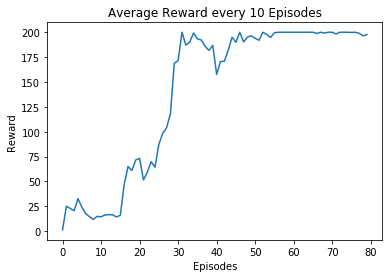

In [42]:
#Plot Average Rewards every 10 Episodes
plt.plot(Cartpole.average_reward)
plt.title('Average Reward every 10 Episodes')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.show()


In [21]:
state = env.reset()
total_reward = 0
while True:
  #env.render()
  predicted_action = np.argmax(Cartpole.agent.model.predict(state.reshape(1, env.observation_space.shape[0])))
  next_state, reward, done, info = env.step(predicted_action)
  total_reward += reward
  state = next_state
  if done:
    # env.close()
    break
print("Total Reward of Trial:", total_reward)

Total Reward of Trial: 200.0


## Acrobot-v1


> The acrobot system includes two joints and two links, where the joint between the two links is actuated. Initially, the links are hanging downwards, and the goal is to swing the end of the lower link up to a given height. Both links can swing freely and can pass by each other, i.e., they don't collide when they have the same angle. A reward of -1 is provided for each timestep for which the goal is not met and the episode terminates after 200 timesteps. If the goal is achieved, the episode terminates.

Actions: [+1 0 -1] where +1, 0 and -1 is the torque applied on the joint between the two links

Observations: [cos(theta1) sin(theta1) cos(theta2) sin(theta2) thetaDot1 thetaDot2] wherer theta1 and theta2 are the two rotational joint angles

Reward: -1 for every timestep spent without achieving the goal





In [22]:
env = gym.make('Acrobot-v1')

Acrobot = Train_Agent(env, batch_size=128, episodes=100, max_memory=100000, epsilon=0.7, epsilon_decay=0.99, hidden_layer_size=32, learning_rate=0.0001, ddqn=False)
Acrobot.Train()

episode: 1/100, score: -500.0, epsilon: 0.7
episode: 2/100, score: -500.0, epsilon: 0.693
episode: 3/100, score: -500.0, epsilon: 0.68607
episode: 4/100, score: -500.0, epsilon: 0.6792092999999999
episode: 5/100, score: -500.0, epsilon: 0.6724172069999999
episode: 6/100, score: -500.0, epsilon: 0.6656930349299999
episode: 7/100, score: -500.0, epsilon: 0.6590361045806998
episode: 8/100, score: -500.0, epsilon: 0.6524457435348928
episode: 9/100, score: -500.0, epsilon: 0.6459212860995439
episode: 10/100, score: -500.0, epsilon: 0.6394620732385484
episode: 11/100, score: -500.0, epsilon: 0.6330674525061629
episode: 12/100, score: -500.0, epsilon: 0.6267367779811013
episode: 13/100, score: -500.0, epsilon: 0.6204694102012902
episode: 14/100, score: -500.0, epsilon: 0.6142647160992774
episode: 15/100, score: -500.0, epsilon: 0.6081220689382846
episode: 16/100, score: -500.0, epsilon: 0.6020408482489017
episode: 17/100, score: -500.0, epsilon: 0.5960204397664127
episode: 18/100, score: -278

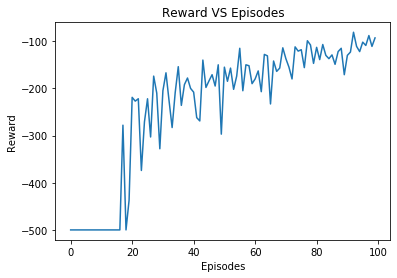

In [23]:
#Rewards VS Episodes
plt.plot(Acrobot.reward_tracker)
plt.title('Reward VS Episodes')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.show()


In [33]:
state = env.reset()
total_reward = 0
while True:
  #env.render()
  predicted_action = np.argmax(Acrobot.agent.model.predict(state.reshape(1, env.observation_space.shape[0])))
  next_state, reward, done, info = env.step(predicted_action)
  total_reward += reward
  state = next_state
  if done:
    # env.close()
    break
print(total_reward)

-95.0


In the two games shown above, Cartpole-v0 and Acrobot-v1, the agent aims at maximizing the reward points at each episode. While the agent's goal in playing Cartpole-v0 is to gain as many +1 reward points as possible during the game, the agent needs to learn to receive as few -1 reward points as possible in order to 'win' or finish the Acrobot-v1 game. The best possible return that we can achieve per episode in the Cartpole-v0 game is 200 units, whereas in the Acrobot-v1 game, the agent cannot achieve a maximum of 0 returns (the reward is -1 for each step) as some number of initial actions(building momentum to swing the arm) are necessary for it to achieve the goal. Increased compute time can ensure reaching a value close to it.

While the same agent can be tuned for optimal performance in both environments, the training and hyperparameter settings required to do so vary. For instance, the size of the layers needed to train the agent to perform optimally, in around the same compute time, differ. Similarly, the number of episodes needed for the agent to learn to get an optimal score in both the games vary as well.


## 2.1 Improving DQN

We use Double DQN as an improvement on our DQN algorithm. The motivation for using Double DQN is to reduce the overestimation of action values by two estimators where one value function estimates the target value and another estimates the action values. We make the following change to:

$Q_{1}(s,a) <-- Q_{1}(s,a) + \alpha (Target - Q_{1}(s,a))$

$\textbf{Q Target:}  r(s, a) + \gamma max_{a'}Q_1(s',a')$

$\textbf{ Double Q Target:}  r(s, a) + \gamma Q_{2}(s',argmax_{a'}Q_1(s',a'))$

The target network's weights $\theta^{-}$ are updated using the following formula:
> $\theta^{-} = \tau\theta + (1-\tau)\theta^{-}$


where $\tau$ is a discount factor

In [14]:
env = gym.make('CartPole-v0')
CartpoleDQN = Train_Agent(env, batch_size=32, episodes=800, gamma=0.9, max_memory =10000, epsilon=1.0, epsilon_decay=0.995, hidden_layer_size=32, learning_rate=0.001, ddqn = True )
CartpoleDQN.Train()

episode: 1/800, score: 23.0, epsilon: 1.0
episode: 2/800, score: 23.0, epsilon: 0.995
episode: 3/800, score: 14.0, epsilon: 0.990025
episode: 4/800, score: 41.0, epsilon: 0.985074875
episode: 5/800, score: 57.0, epsilon: 0.9801495006250001
episode: 6/800, score: 22.0, epsilon: 0.9752487531218751
episode: 7/800, score: 13.0, epsilon: 0.9703725093562657
episode: 8/800, score: 19.0, epsilon: 0.9655206468094844
episode: 9/800, score: 18.0, epsilon: 0.960693043575437
episode: 10/800, score: 16.0, epsilon: 0.9558895783575597
episode: 11/800, score: 13.0, epsilon: 0.9511101304657719
episode: 12/800, score: 13.0, epsilon: 0.946354579813443
episode: 13/800, score: 11.0, epsilon: 0.9416228069143757
episode: 14/800, score: 11.0, epsilon: 0.9369146928798039
episode: 15/800, score: 24.0, epsilon: 0.9322301194154049
episode: 16/800, score: 15.0, epsilon: 0.9275689688183278
episode: 17/800, score: 10.0, epsilon: 0.9229311239742362
episode: 18/800, score: 17.0, epsilon: 0.918316468354365
episode: 19/8

episode: 143/800, score: 81.0, epsilon: 0.4907693883854626
episode: 144/800, score: 93.0, epsilon: 0.4883155414435353
episode: 145/800, score: 13.0, epsilon: 0.4858739637363176
episode: 146/800, score: 114.0, epsilon: 0.483444593917636
episode: 147/800, score: 16.0, epsilon: 0.4810273709480478
episode: 148/800, score: 44.0, epsilon: 0.47862223409330756
episode: 149/800, score: 68.0, epsilon: 0.47622912292284103
episode: 150/800, score: 144.0, epsilon: 0.4738479773082268
episode: 151/800, score: 30.0, epsilon: 0.47147873742168567
episode: 152/800, score: 54.0, epsilon: 0.46912134373457726
episode: 153/800, score: 176.0, epsilon: 0.46677573701590436
episode: 154/800, score: 50.0, epsilon: 0.46444185833082485
episode: 155/800, score: 113.0, epsilon: 0.46211964903917074
episode: 156/800, score: 91.0, epsilon: 0.4598090507939749
episode: 157/800, score: 26.0, epsilon: 0.457510005540005
episode: 158/800, score: 47.0, epsilon: 0.45522245551230495
episode: 159/800, score: 156.0, epsilon: 0.452

episode: 281/800, score: 159.0, epsilon: 0.2457325055235537
episode: 282/800, score: 188.0, epsilon: 0.24450384299593592
episode: 283/800, score: 22.0, epsilon: 0.24328132378095624
episode: 284/800, score: 158.0, epsilon: 0.24206491716205145
episode: 285/800, score: 44.0, epsilon: 0.2408545925762412
episode: 286/800, score: 44.0, epsilon: 0.23965031961336
episode: 287/800, score: 66.0, epsilon: 0.2384520680152932
episode: 288/800, score: 48.0, epsilon: 0.23725980767521673
episode: 289/800, score: 135.0, epsilon: 0.23607350863684065
episode: 290/800, score: 140.0, epsilon: 0.23489314109365644
episode: 291/800, score: 78.0, epsilon: 0.23371867538818816
episode: 292/800, score: 122.0, epsilon: 0.23255008201124722
episode: 293/800, score: 122.0, epsilon: 0.231387331601191
episode: 294/800, score: 200.0, epsilon: 0.23023039494318503
episode: 295/800, score: 123.0, epsilon: 0.2290792429684691
episode: 296/800, score: 16.0, epsilon: 0.22793384675362674
episode: 297/800, score: 22.0, epsilon: 

episode: 418/800, score: 98.0, epsilon: 0.12365869841532712
episode: 419/800, score: 112.0, epsilon: 0.12304040492325048
episode: 420/800, score: 166.0, epsilon: 0.12242520289863423
episode: 421/800, score: 200.0, epsilon: 0.12181307688414106
episode: 422/800, score: 200.0, epsilon: 0.12120401149972035
episode: 423/800, score: 21.0, epsilon: 0.12059799144222175
episode: 424/800, score: 98.0, epsilon: 0.11999500148501063
episode: 425/800, score: 145.0, epsilon: 0.11939502647758558
episode: 426/800, score: 131.0, epsilon: 0.11879805134519765
episode: 427/800, score: 138.0, epsilon: 0.11820406108847166
episode: 428/800, score: 41.0, epsilon: 0.1176130407830293
episode: 429/800, score: 200.0, epsilon: 0.11702497557911415
episode: 430/800, score: 200.0, epsilon: 0.11643985070121858
episode: 431/800, score: 54.0, epsilon: 0.11585765144771248
episode: 432/800, score: 105.0, epsilon: 0.11527836319047392
episode: 433/800, score: 200.0, epsilon: 0.11470197137452155
episode: 434/800, score: 55.0,

episode: 555/800, score: 19.0, epsilon: 0.0996820918179746
episode: 556/800, score: 28.0, epsilon: 0.0996820918179746
episode: 557/800, score: 106.0, epsilon: 0.0996820918179746
episode: 558/800, score: 200.0, epsilon: 0.0996820918179746
episode: 559/800, score: 127.0, epsilon: 0.0996820918179746
episode: 560/800, score: 108.0, epsilon: 0.0996820918179746
episode: 561/800, score: 137.0, epsilon: 0.0996820918179746
episode: 562/800, score: 123.0, epsilon: 0.0996820918179746
episode: 563/800, score: 17.0, epsilon: 0.0996820918179746
episode: 564/800, score: 111.0, epsilon: 0.0996820918179746
episode: 565/800, score: 139.0, epsilon: 0.0996820918179746
episode: 566/800, score: 45.0, epsilon: 0.0996820918179746
episode: 567/800, score: 11.0, epsilon: 0.0996820918179746
episode: 568/800, score: 181.0, epsilon: 0.0996820918179746
episode: 569/800, score: 115.0, epsilon: 0.0996820918179746
episode: 570/800, score: 20.0, epsilon: 0.0996820918179746
episode: 571/800, score: 44.0, epsilon: 0.0996

episode: 693/800, score: 200.0, epsilon: 0.0996820918179746
episode: 694/800, score: 58.0, epsilon: 0.0996820918179746
episode: 695/800, score: 136.0, epsilon: 0.0996820918179746
episode: 696/800, score: 200.0, epsilon: 0.0996820918179746
episode: 697/800, score: 200.0, epsilon: 0.0996820918179746
episode: 698/800, score: 168.0, epsilon: 0.0996820918179746
episode: 699/800, score: 94.0, epsilon: 0.0996820918179746
episode: 700/800, score: 136.0, epsilon: 0.0996820918179746
episode: 701/800, score: 49.0, epsilon: 0.0996820918179746
episode: 702/800, score: 58.0, epsilon: 0.0996820918179746
episode: 703/800, score: 200.0, epsilon: 0.0996820918179746
episode: 704/800, score: 122.0, epsilon: 0.0996820918179746
episode: 705/800, score: 123.0, epsilon: 0.0996820918179746
episode: 706/800, score: 65.0, epsilon: 0.0996820918179746
episode: 707/800, score: 200.0, epsilon: 0.0996820918179746
episode: 708/800, score: 135.0, epsilon: 0.0996820918179746
episode: 709/800, score: 89.0, epsilon: 0.099

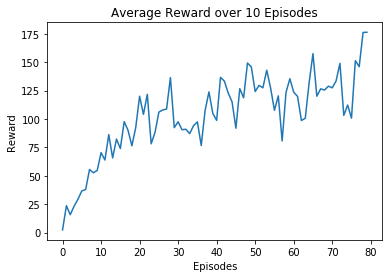

In [41]:
#Plot Average Rewards every 10 Episodes
plt.plot(CartpoleDQN.average_reward)
plt.title('Average Reward over 10 Episodes')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.show()

In [44]:
state = env.reset()
total_reward = 0
while True:
  predicted_action = np.argmax(CartpoleDQN.agent.model.predict(state.reshape(1, env.observation_space.shape[0])))
  next_state, reward, done, info = env.step(predicted_action)
  env.render()
  total_reward += reward
  state = next_state
  if done:
    env.close()
    break
    
print("Total reward for the trial", total_reward)

Total reward for the trial 200.0


## Result: DQN VS Double DQN


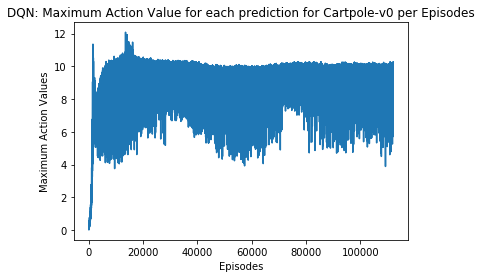

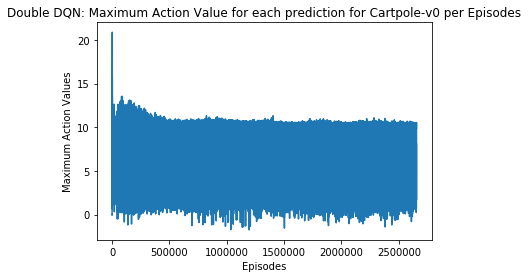

In [45]:
#plot of Maximum Action Values for DQN vs Episode
plt.plot([np.amax(x) for x in Cartpole.agent.history])
plt.title('DQN: Maximum Action Value for each prediction for Cartpole-v0 per Episodes')
plt.xlabel('Episodes')
plt.ylabel('Maximum Action Values')
plt.show()

#plot of Maximum Action Values for DDQN vs Episode
plt.plot([np.amax(x) for x in CartpoleDQN.agent.history])
plt.title('Double DQN: Maximum Action Value for each prediction for Cartpole-v0 per Episodes')
plt.xlabel('Episodes')
plt.ylabel('Maximum Action Values')
plt.show()


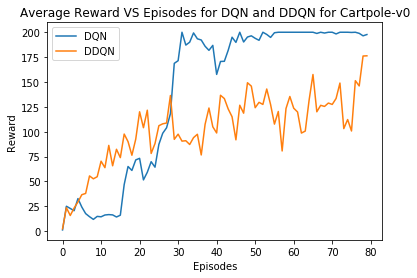

In [46]:
#plot Aveage Rewards vs Episode
plt.subplot()
plt.plot(Cartpole.average_reward)
# plt.legend('DQN')
plt.plot(CartpoleDQN.average_reward)
plt.legend(["DQN",'DDQN'])
plt.title('Average Reward VS Episodes for DQN and DDQN for Cartpole-v0')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.show()


The purpose of using Double DQN as an improvement on our DQN Algorithm for the game Cartpole-v0 was to stabilize the predicted action values. The first two graphs show the predictions of the two algorithms recorded during training( 32 observations per batch * 800 episodes = 25600). As we can observe, the predictions of Double DQN are stable over the episodes while DQN values vary over episodes. 
The next graph shows the variation in rewards for DQN and Double DQN over 800 episodes of playing Cartpole-v0. Although the graphs begin with Double DQN performing better for the initial few episodes, DQN takes over in the later stages and outperforms Double DQN. The expecation of the Double DQN algorithm is to improve stability and hence performance of the DQN algorithm. The results shown are over a few episodes of training and possibly with more compute time and better tuning of the hyperparameters a better performance of Double DQN can be achieved over DQN.